- 참고: https://medium.com/@codecompose/unet-480d378906fd
- 참고(torch 구현): https://wsshin.tistory.com/2
- 참고(torch 구현 github): https://github.com/wooseok-shin/code_implementation

# 프로젝트 : 개선된 U-Net 모델 만들기
U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느 정도 동작하는 것 같긴 하지만 좀 더 개선할 여지도 보일 것입니다.

2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다. 논문은 2020년에 한 번 업그레이드가 되었네요.

- [U-Net++: v1](https://arxiv.org/abs/1807.10165)
- [U-Net++: v2](https://arxiv.org/abs/1912.05074)

모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU 값을 비교해 보면 될 것입니다.

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-5-P-UNPP.max-800x600.png)

- [U-Net++:Github](https://github.com/MrGiovanni/UNetPlusPlus)
코드 중에서 가장 중요한 부분도 알려드리자면 여기:[build_xnet](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12)입니다. 논문에서 제시하는 수식과 함께 참고하세요.

![img](https://d3s0tskafalll9.cloudfront.net/media/images/gc-5v2-p-4-1.max-800x600.png)

코드 중 up_block으로는 두 가지 방식을 사용하고 있네요. [Transpose2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L53)과 [Upsample2D_block]()https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L28인데요. 둘 중 어느 것을 사용해도 좋습니다.

또 한 가지 주의해야 할 점은 Loss를 조금 다르게 구현해야 한다는 점입니다. binary cross-entropy와 dice coefficient를 사용한다고 하는데요. [dice_coef](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)에 구현된 dice coefficient를 참고해 보세요.

![img](https://d3s0tskafalll9.cloudfront.net/media/images/gc-5v2-p-4-2.max-800x600.png)

프로젝트 진행에 필요한 주요 라이브러리 버전 체크를 해봅시다.

In [1]:
# tensorflow 로 구현하기 위해서 필요한 module
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

# Torch로 구현하기 위해서 필요한 module import 
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import OrderedDict
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.nn import init
import torchvision.transforms.functional as F
import torchvision

# image processing
import PIL
from PIL import Image
import skimage
from skimage.io import imread
from skimage.transform import resize
import albumentations
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize
import matplotlib.pyplot as plt
import cv2
from albumentations.augmentations import transforms

# file 
from glob import glob
import os

# etc
import math

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

/Users/louan/.pyenv/versions/3.10.5/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.11.0
1.24.2
9.4.0
0.20.0
1.3.0


### Step 1. KITTI 데이터셋 수집과 구축
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

In [2]:
def build_augmentation(height = 224 , width = 224, is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(min_max_height=(300, 370), 
                                    w2h_ratio=370/1242, 
                                    height=height, width=width, p=0.5),# 50%의 확률로 RandomSizedCrop
                    Resize(width=width,height=height)]) # 입력이미지를 224X224로 resize
  else:                  
    return Compose([ Resize(width=width,height=height) ])# 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 

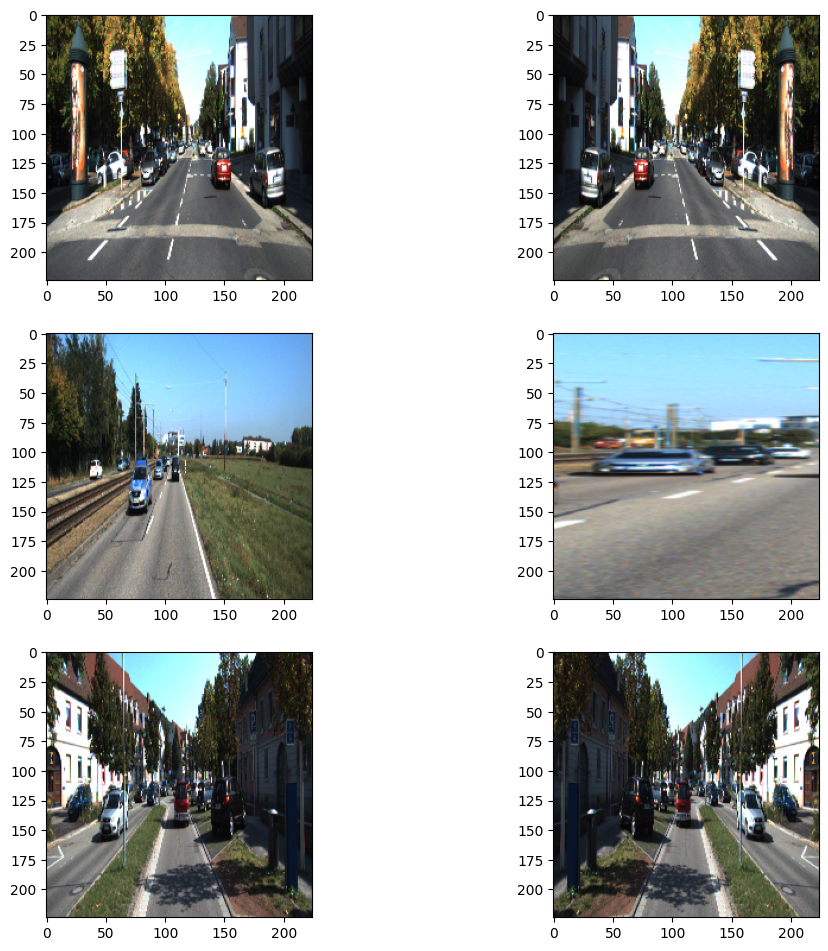

In [3]:
dir_path = '../data/230228/training/'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(3):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
def build_augmentation_torch(height = 224 , width = 224, is_train=True):
    if is_train:    # 훈련용 데이터일 경우
      return Compose([HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                      RandomSizedCrop(min_max_height=(300, 370), 
                                      w2h_ratio=370/1242, 
                                      height=height, width=width, p=0.5),# 50%의 확률로 RandomSizedCrop
                      # torchvision.transforms.ToTensor(),
                      Resize(height,width)]) # 입력이미지를 224X224로 resize
    else:                  
      return Compose([Resize(height,width)])# 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 

In [5]:
# pytorch image dimension --> batch, channels, height, width
# 참고: https://discuss.pytorch.org/t/dimensions-of-an-input-image/19439
# image processing for pytorch: https://csm-kr.tistory.com/36
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, dir_path, batch_size=16, img_size=(3, 224, 224), output_size=(224, 224), is_train=True, augmentation=None, is_torch =False):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size
    
    self.is_torch = is_torch
    
    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images_file_lst = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images_file_lst = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images_file_lst.sort()
    label_images_file_lst.sort()
    assert len(input_images_file_lst) == len(label_images_file_lst)
    file_lst_data = [ _ for _ in zip(input_images_file_lst, label_images_file_lst)]

    if self.is_train:
      return file_lst_data[:-30]
    return file_lst_data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[index*self.batch_size:
                           (index + 1)*self.batch_size]
    
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
  
    for i, data in enumerate(batch_data):
      input_img_path, output_img_path = data
      _input = imread(input_img_path)
      _output = imread(output_img_path)
      
      _output = (_output==7).astype(np.uint8)*1
      
      data = {"image": _input,"mask": _output}
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes
    



In [19]:
class KittiGenerator_torch(Dataset):
  def __init__(self, dir_path, img_size=(3, 224, 224), output_size=(224, 224), is_train=True, augmentation=None):
      '''
      dir_path: dataset의 directory path입니다.
      batch_size: batch_size입니다.
      img_size: preprocess에 사용할 입력이미지의 크기입니다.
      output_size: ground_truth를 만들어주기 위한 크기입니다.
      is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
      augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
      '''
      self.dir_path = dir_path
      self.is_train = is_train
      self.augmentation = augmentation
      self.img_size = img_size
      self.output_size = output_size
      
      # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
      self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images_file_lst = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images_file_lst = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images_file_lst.sort()
    label_images_file_lst.sort()
    assert len(input_images_file_lst) == len(label_images_file_lst)
    file_lst_data = [ _ for _ in zip(input_images_file_lst, label_images_file_lst)]

    if self.is_train:
      return file_lst_data[:-30]
    return file_lst_data[-30:]

  def __getitem__(self, idx):
    
    _, height, width = self.img_size
    # for i, data in enumerate(batch_data):
    # input_img_path, output_img_path = data 
    input_img_path, output_img_path = self.data[idx] # test
    
    _input = cv2.imread(input_img_path)
    _input = cv2.cvtColor(_input, cv2.COLOR_BGR2RGB)
    
    _output = cv2.imread(output_img_path)
    # _output = torchvision.transforms.Resize((height, width))(_output)
    _output = cv2.cvtColor(_output, cv2.COLOR_BGR2GRAY) / 255
    _output = np.expand_dims(_output, axis=-1)
    
    augmented = self.augmentation(image=_input, mask=_output)

    inputs_torch = augmented['image']
    outputs_torch = augmented['mask']

    inputs_torch = inputs_torch.transpose(2, 0, 1)
    outputs_torch = outputs_torch.transpose(2, 0, 1)
    
    return  torch.from_numpy(inputs_torch), torch.from_numpy(outputs_torch)

  def __len__(self): 
    return len(self.dir_path)

#### Data Loading

In [21]:
dir_path = '../data/230228/training/'
batch_size = 8
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator_tf = KittiGenerator(dir_path, img_size = (224,224,3), augmentation=augmentation, batch_size= batch_size)
test_generator_tf = KittiGenerator(dir_path, img_size = (224,224,3), augmentation=test_preproc, batch_size= batch_size, is_train=False)

augmentation_torch = build_augmentation_torch() # test
test_preproc_torch = build_augmentation_torch(is_train=False) #test
train_generator_torch = KittiGenerator_torch(dir_path, img_size = (3, 224,224), augmentation=augmentation_torch)
test_generator_torch = KittiGenerator_torch(dir_path, img_size = (3, 224,224), augmentation=test_preproc_torch, is_train=False)

### Step 2. U-Net++ 모델의 구현
#### Tensorflow로 Unet 사용
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

In [8]:
# 여기에서는 사전 저장된 Unet Model을 사용하겠습니다.
# Tensorflow version 입니다.
# def build_model_Unet(input_shape=(224, 224, 3)):
#   inputs = Input(input_shape)
	
#   #Contracting Path
#   conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
#   conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
#   pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#   conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
#   conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
#   pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#   conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
#   conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
#   pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#   conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
#   conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
#   drop4 = Dropout(0.5)(conv4)
#   pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
#   conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
#   conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
#   #Expanding Path
#   drop5 = Dropout(0.5)(conv5)
#   up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
#   merge6 = concatenate([drop4,up6], axis = 3)
#   conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
#   conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
#   up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
#   merge7 = concatenate([conv3,up7], axis = 3)
#   conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
#   conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
#   up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
#   merge8 = concatenate([conv2,up8], axis = 3)
#   conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
#   conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
#   up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
#   merge9 = concatenate([conv1,up9], axis = 3)
#   conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
#   conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
#   conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
#   conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

#   model = Model(inputs = inputs, outputs = conv10)
#   return model

In [9]:
model_path = '../data/230228/seg_model_unet.h5'
unet_model = tf.keras.models.load_model(model_path)

opt = keras.optimizers.legacy.Adam(learning_rate= 1e-4)
unet_model.compile(optimizer = opt, loss = 'binary_crossentropy')
unet_model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-09 02:43:52.308797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-09 02:43:52.308816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_23[0][0]']              
                                )                                                           

In [27]:
unet_model.fit(
     train_generator_tf,
     validation_data=test_generator_tf,
     steps_per_epoch=len(train_generator_tf),
     epochs=100,
)

Epoch 1/100


2023-03-09 02:51:31.568647: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-09 02:51:33.669972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.0334

2023-03-09 02:52:03.883748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 34s 1s/step - loss: 0.0334 - val_loss: 0.0316
Epoch 2/100
22/22 [==============================] - 31s 1s/step - loss: 0.0249 - val_loss: 0.0272
Epoch 3/100
22/22 [==============================] - 31s 1s/step - loss: 0.0258 - val_loss: 0.0344
Epoch 4/100
22/22 [==============================] - 31s 1s/step - loss: 0.0266 - val_loss: 0.0338
Epoch 5/100
22/22 [==============================] - 32s 1s/step - loss: 0.0475 - val_loss: 0.0475
Epoch 6/100
22/22 [==============================] - 32s 1s/step - loss: 0.0337 - val_loss: 0.0311
Epoch 7/100
 2/22 [=>............................] - ETA: 27s - loss: 0.0481

#### Pytorch로 Unet++ 구현

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [11]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def iou_score(output, target, threshold=0.5):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > threshold
    target_ = target > threshold
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

In [12]:
class Unet_block(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

In [13]:
class Nested_UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False):
        super().__init__()

        num_filter = [32, 64, 128, 256, 512]
        self.deep_supervision = deep_supervision
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # DownSampling
        self.conv0_0 = Unet_block(input_channels, num_filter[0], num_filter[0])
        self.conv1_0 = Unet_block(num_filter[0], num_filter[1], num_filter[1])
        self.conv2_0 = Unet_block(num_filter[1], num_filter[2], num_filter[2])
        self.conv3_0 = Unet_block(num_filter[2], num_filter[3], num_filter[3])
        self.conv4_0 = Unet_block(num_filter[3], num_filter[4], num_filter[4])

        # Upsampling & Dense skip
        # N to 1 skip
        self.conv0_1 = Unet_block(num_filter[0] + num_filter[1], num_filter[0], num_filter[0])
        self.conv1_1 = Unet_block(num_filter[1] + num_filter[2], num_filter[1], num_filter[1])
        self.conv2_1 = Unet_block(num_filter[2] + num_filter[3], num_filter[2], num_filter[2])
        self.conv3_1 = Unet_block(num_filter[3] + num_filter[4], num_filter[3], num_filter[3])
       
        # N to 2 skip
        self.conv0_2 = Unet_block(num_filter[0]*2 + num_filter[1], num_filter[0], num_filter[0])
        self.conv1_2 = Unet_block(num_filter[1]*2 + num_filter[2], num_filter[1], num_filter[1])
        self.conv2_2 = Unet_block(num_filter[2]*2 + num_filter[3], num_filter[2], num_filter[2])

        # N to 3 skip
        self.conv0_3 = Unet_block(num_filter[0]*3 + num_filter[1], num_filter[0], num_filter[0])
        self.conv1_3 = Unet_block(num_filter[1]*3 + num_filter[2], num_filter[1], num_filter[1])

        # N to 4 skip
        self.conv0_4 = Unet_block(num_filter[0]*4 + num_filter[1], num_filter[0], num_filter[0])

        if self.deep_supervision:
            self.output1 = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)
            self.output2 = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)
            self.output3 = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)
            self.output4 = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)

        else:
            self.output = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, x):                    # (Batch, 3, 256, 256)

        x0_0 = self.conv0_0(x)               
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], dim=1))
        
        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], dim=1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], dim=1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], dim=1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], dim=1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], dim=1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], dim=1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], dim=1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], dim=1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], dim=1))

        if self.deep_supervision:
            output1 = self.output1(x0_1)
            output2 = self.output2(x0_2)
            output3 = self.output3(x0_3)
            output4 = self.output4(x0_4)
            output = (output1 + output2 + output3 + output4) / 4
        else:
            output = self.output(x0_4)

        return output

In [14]:
# M1 gpu: https://bio-info.tistory.com/184
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps:0


In [15]:
# 참고(loss): https://nuguziii.github.io/dev/dev-002/
unetPP_model = Nested_UNet(1, 3, deep_supervision=False).to(device)
criterion = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')
optimizer = torch.optim.SGD(params=unetPP_model.parameters(), lr=1e-4)

In [16]:
# 참고(tensorflow vs pytorch, model fit): https://acdongpgm.tistory.com/231

def train(train_loader, model, criterion, optimizer):
    avg_meters = {'loss':AverageMeter(),
                  'iou' :AverageMeter()}

    model.train()
    for inputs, labels in train_loader:
        inputs = torch.tensor(inputs, device=device, dtype=torch.float32)
        labels = torch.tensor(labels, device=device, dtype=torch.float32)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # log
        iou = iou_score(outputs, labels, threshold=0.8)
        avg_meters['loss'].update(loss.item(), n=inputs.size(0))
        avg_meters['iou'].update(iou, n=inputs.size(0))

        log = OrderedDict([
                    ('loss', avg_meters['loss'].avg),
                    ('iou', avg_meters['iou'].avg),
                ])
    return log, model

def validation(val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = torch.tensor(inputs, device=device, dtype=torch.float32)
            labels = torch.tensor(labels, device=device, dtype=torch.float32)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            iou = iou_score(outputs, labels, threshold=0.8)

            avg_meters['loss'].update(loss.item(), n=inputs.size(0))
            avg_meters['iou'].update(iou, n=inputs.size(0))

            log = OrderedDict([
                        ('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                    ])
    return log

In [22]:
train_loader = DataLoader(train_generator_torch, batch_size=8, shuffle=True)
val_loader = DataLoader(test_generator_torch, batch_size=8, shuffle=False)

In [26]:
epochs=20
best_iou = 0
for epoch in range(1, epochs+1):
    train_log, model = train(train_loader, unetPP_model, criterion, optimizer)
    val_log =  validation(val_loader, model, criterion)
    print(f'{epoch}Epoch')
    print(f'train loss:{train_log["loss"]:.3f} |train iou:{train_log["iou"]:.3f}')
    print(f'val loss:{val_log["loss"]:.3f} |val iou:{val_log["iou"]:.3f}\n')
    valid_iou = val_log['iou']
    if best_iou < valid_iou:
        best_iou = valid_iou
        torch.save(model.state_dict(), f'../data/230228/results/unet/best_model.pth')

/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_42288/2300933466.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, device=device, dtype=torch.float32)
/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_42288/2300933466.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device, dtype=torch.float32)
/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_42288/2300933466.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inpu

1Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

2Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

3Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

4Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

5Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

6Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

7Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

8Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

9Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

10Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

11Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

12Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

13Epoch
train loss:100.000 |train iou:1.000
val loss:100.000 |val iou:1.000

14Epoch


### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
# UnetPP_model은 Unet++ 모델입니다.
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unetPP_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)